In [3]:
# from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [59]:
# uploaded = files.upload()

In [4]:
data = pd.read_csv("diabetes_prediction_dataset.csv", delimiter=",")

df = pd.DataFrame(data)

df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


# Analisis de Outliers por Histograma

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'hypertension'}>,
        <Axes: title={'center': 'heart_disease'}>],
       [<Axes: title={'center': 'bmi'}>,
        <Axes: title={'center': 'HbA1c_level'}>,
        <Axes: title={'center': 'blood_glucose_level'}>],
       [<Axes: title={'center': 'diabetes'}>, <Axes: >, <Axes: >]],
      dtype=object)

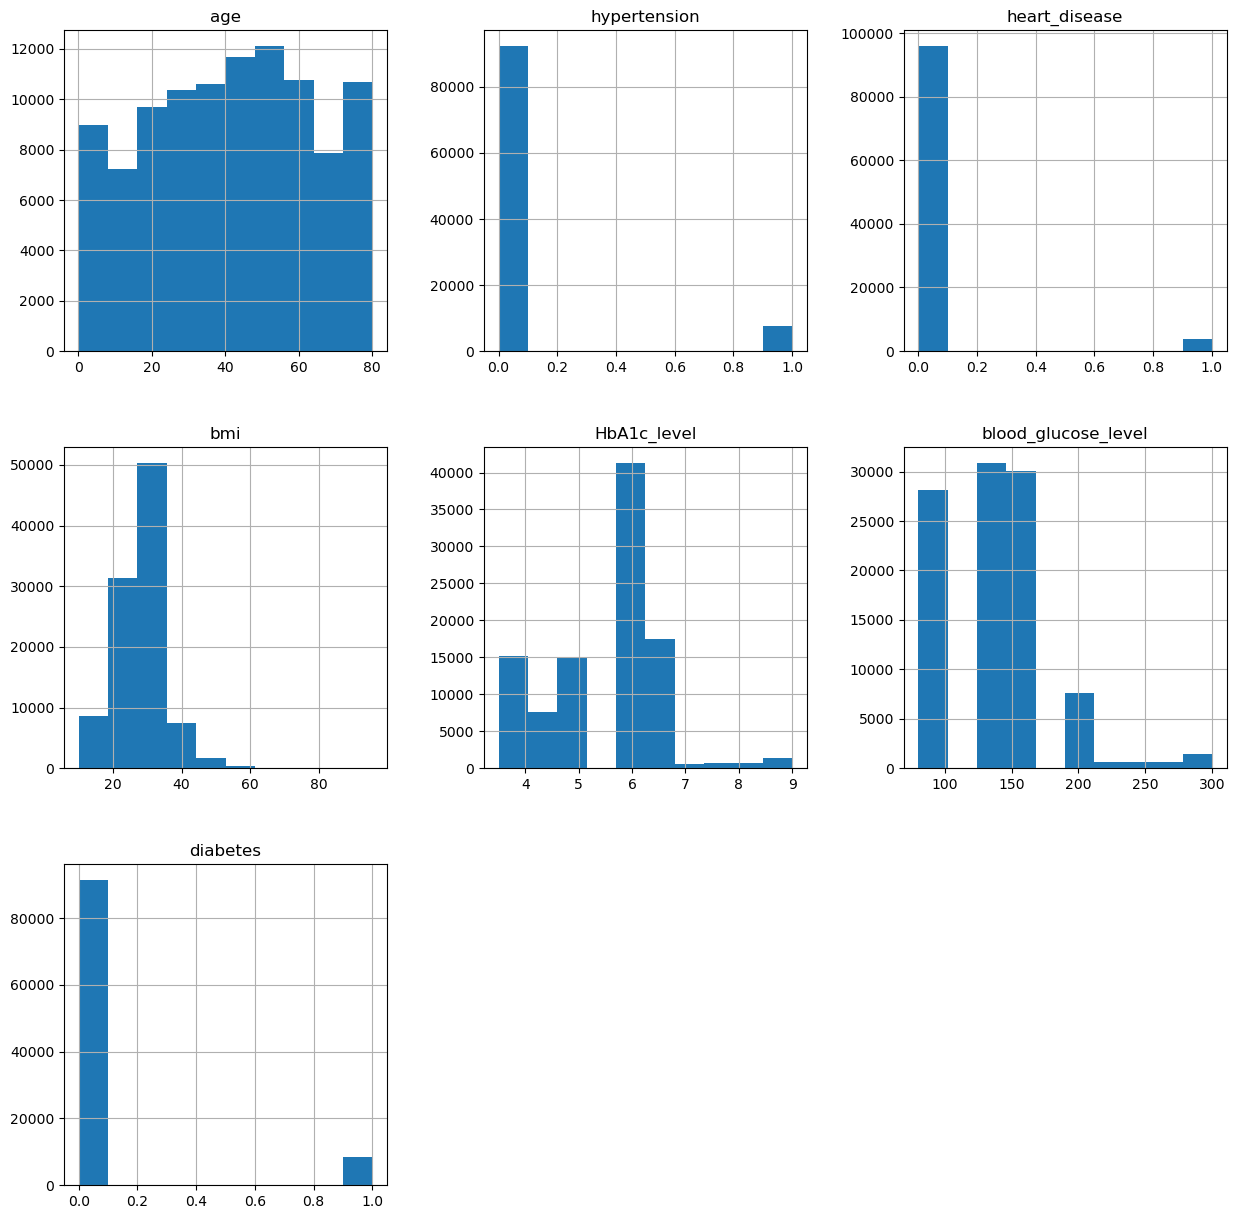

In [5]:
df.hist(figsize=(15, 15)) # Histogramas de todas las columnas

<Axes: xlabel='age', ylabel='Count'>

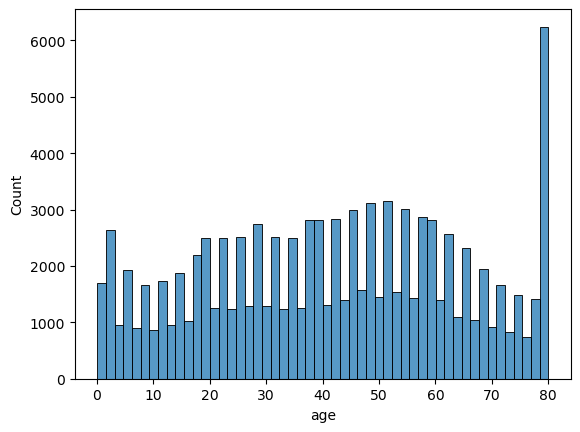

In [6]:
sns.histplot(df["age"])

<Axes: xlabel='bmi', ylabel='Count'>

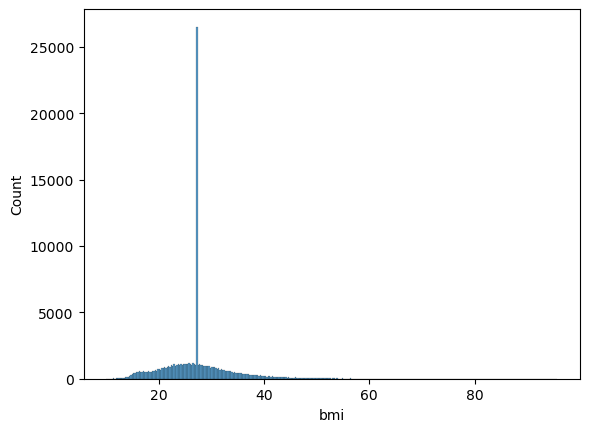

In [7]:
# sns.histplot(df[(df["bmi"] >= 27.320) & (df["bmi"] <= 27.330)])
sns.histplot(df["bmi"])

<Axes: xlabel='HbA1c_level', ylabel='Count'>

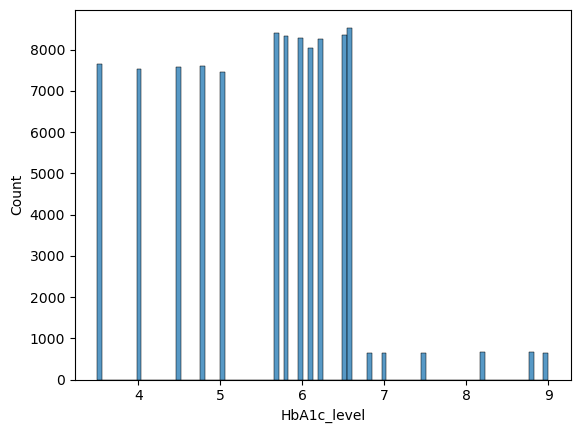

In [8]:
sns.histplot(df["HbA1c_level"])

<Axes: xlabel='blood_glucose_level', ylabel='Count'>

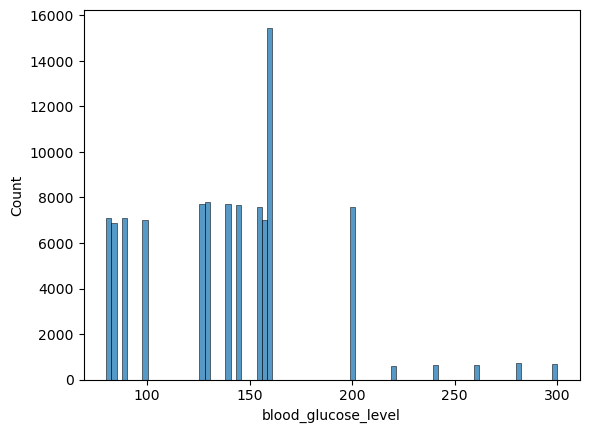

In [9]:
sns.histplot(df["blood_glucose_level"])

# Analisis de Outliers por Rango Intercuartilico (IQR)

In [11]:
def outliers_IQR(column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  upper_bound = Q3 + 1.5 * IQR
  lower_bound = Q1 - 1.5 * IQR

  outliers = df[(df[column] > upper_bound) | (df[column] < lower_bound)]
  return outliers

<Axes: xlabel='bmi', ylabel='Count'>

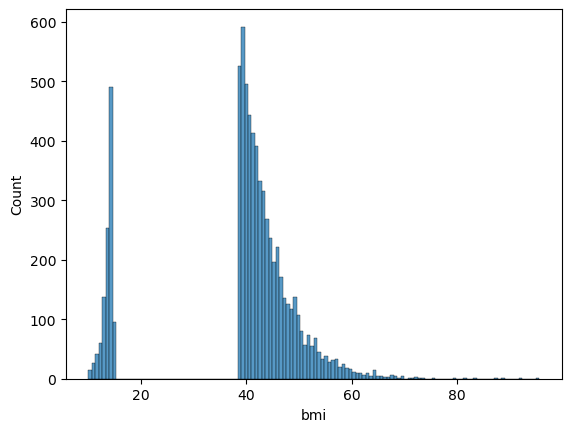

In [12]:
sns.histplot(outliers_IQR("bmi")["bmi"])

<Axes: xlabel='HbA1c_level', ylabel='Count'>

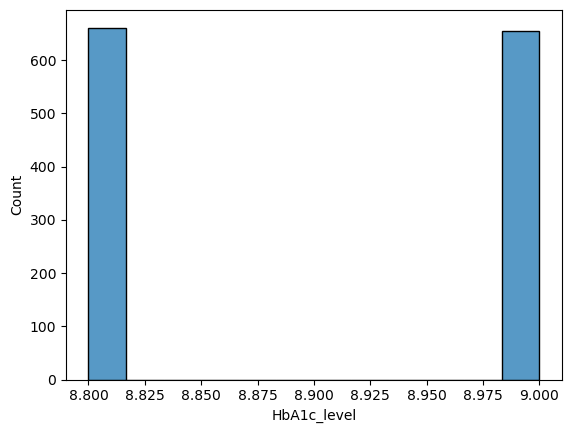

In [13]:
sns.histplot(outliers_IQR("HbA1c_level")["HbA1c_level"])

<Axes: xlabel='blood_glucose_level', ylabel='Count'>

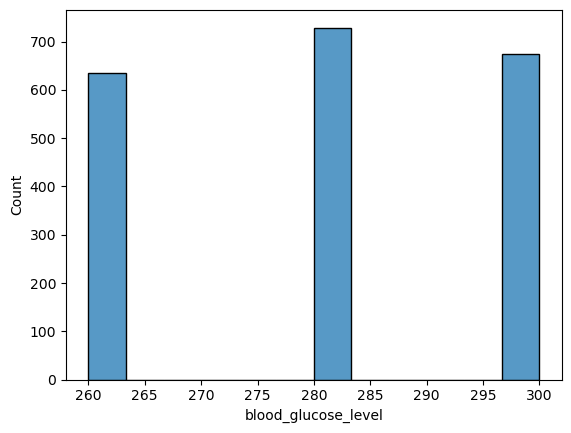

In [69]:
sns.histplot(outliers_IQR("blood_glucose_level")["blood_glucose_level"])

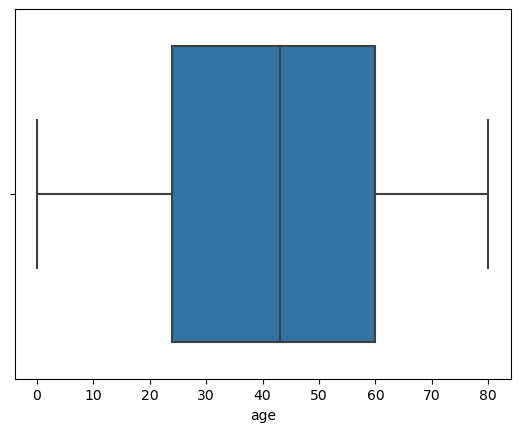

In [70]:
sns.boxplot(x=df["age"])
plt.show()

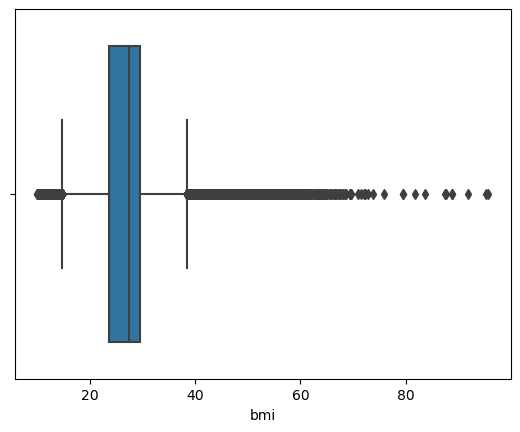

In [71]:
sns.boxplot(x=df["bmi"])
plt.show()

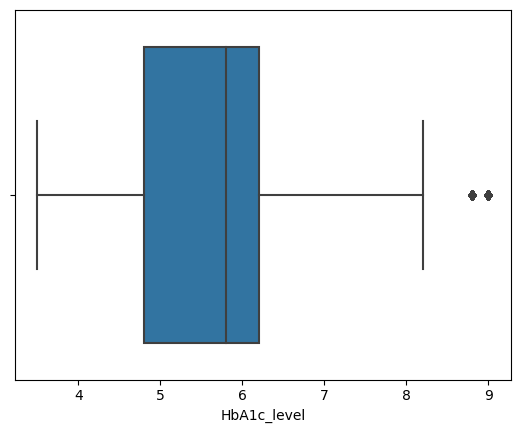

In [72]:
sns.boxplot(x=df["HbA1c_level"])
plt.show()

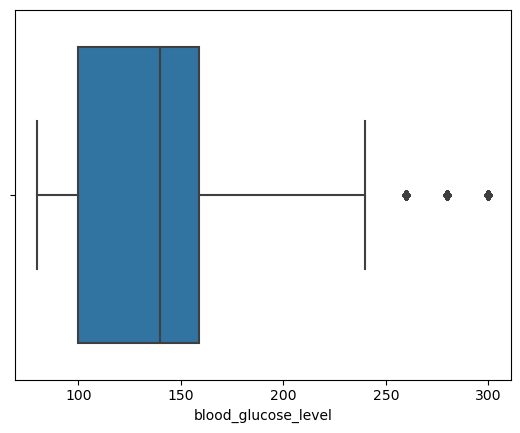

In [73]:
sns.boxplot(x=df["blood_glucose_level"])
plt.show()

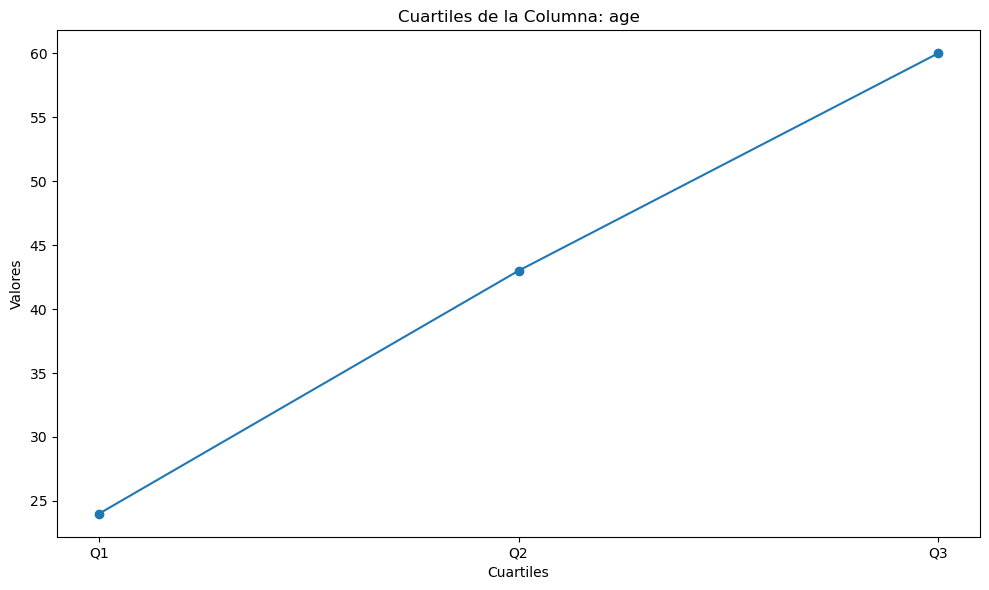

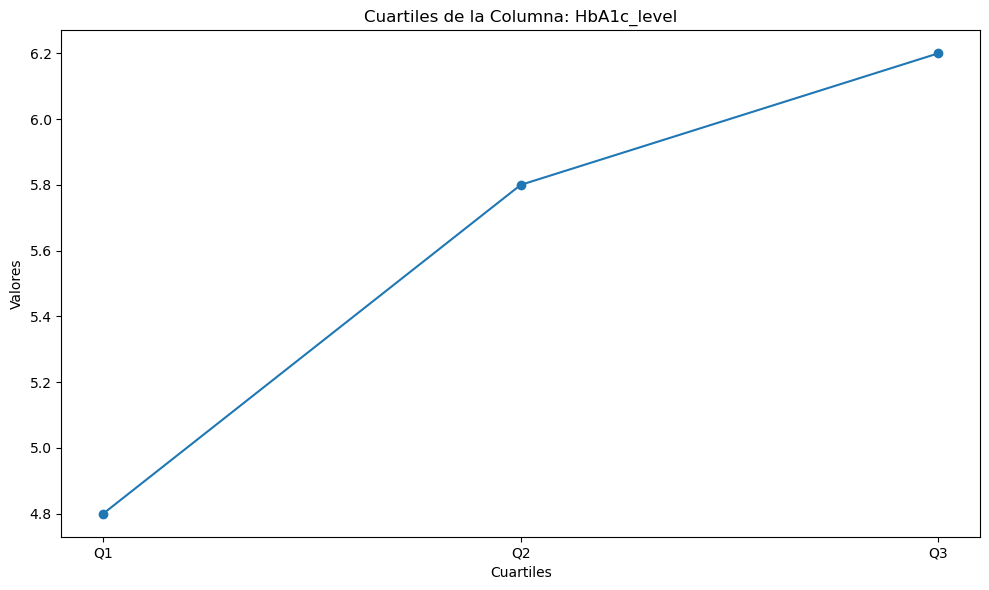

In [74]:
def plot_quartiles(df, column_name):
    # Configurar el diseño del gráfico
    fig, ax = plt.subplots(figsize=(10, 6))

    # Calcular los cuartiles para la columna especificada
    quartiles = df[column_name].quantile([0.25, 0.5, 0.75])

    # Graficar los cuartiles
    ax.plot(["Q1", "Q2", "Q3"], quartiles, marker='o')

    # Añadir las etiquetas de los ejes y el título
    ax.set_xlabel('Cuartiles')
    ax.set_ylabel('Valores')
    ax.set_title(f'Cuartiles de la Columna: {column_name}')

    plt.tight_layout()
    plt.show()

plot_quartiles(df, "age")
plot_quartiles(df, "HbA1c_level")

# El punto Q2 representa la mediana, si Q2 esta por arriba del centro o por debajo nos indica que tanto se asemejan los datos a una distribucion normal

# Remocion de Outliers

In [14]:
# Decidi eliminar filas que contengan:

df = df[df["smoking_history"] != "No Info"] # -> No respondio, no lo considero confiable
df = df[df["smoking_history"] != "ever"] # -> Parece un typo, no lo considero confiable
df = df[df["age"] != 80] # -> Cantidad de filas anormal para la distribucion general de la variable
df = df[df["bmi"] != 27.32] # -> Cantidad de filas anormal para la distribucion general de la variable

df = df[~df["bmi"].isin(outliers_IQR("bmi")["bmi"])] # -> Valores por fuera de las dos desviaciones estandar detectados con IQR

# Normalizacion

In [15]:
gender = {
    "Male": 0,
    "Female": 1
}

smoking_history = {
    "never": 0,
    "current": 1,
    "not current": 2,
    "former": 3
}

def reemplazar_categorica(dictionary, targetDf, targetColumn):
  targetDf[targetColumn] = targetDf[targetColumn].replace(dictionary).astype(int)

def reemplazar_rango(valor, diccionario):
  for (rango_primero, rango_segundo), nuevo_valor in diccionario.items():
    if rango_primero <= valor < rango_segundo:
      return nuevo_valor
  return 0

reemplazar_categorica(gender, df, "gender")
reemplazar_categorica(smoking_history, df, "smoking_history")

In [25]:
def min_max_scaler(df, columnas):
    for columna in columnas:
        minimo = df[columna].min()
        maximo = df[columna].max()

        df[columna] = (df[columna] - minimo) / (maximo - minimo)
    return df

columnas_a_escalar = ["age", "bmi", "HbA1c_level", "blood_glucose_level"]
df_escalado = min_max_scaler(df.copy(), columnas_a_escalar)

df_escalado.describe()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
count,44789.000000,44789.000000,44789.000000,44789.000000,44789.000000,44789.000000,44789.000000,44789.000000,44789.000000
mean,0.611981,0.559253,0.094287,0.039027,0.795999,0.497440,0.373845,0.269568,0.103552
std,0.487304,0.235051,0.292230,0.193662,1.121942,0.177507,0.198012,0.190284,0.304682
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.365804,0.000000,0.000000,0.000000,0.367906,0.236364,0.090909,0.000000
50%,1.000000,0.568747,0.000000,0.000000,0.000000,0.478334,0.418182,0.272727,0.000000
75%,1.000000,0.746322,0.000000,0.000000,1.000000,0.609170,0.490909,0.359091,0.000000
max,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
def z_score(df): # "Normalizacion"
    columns = df[df.columns]
    columns = columns.drop(columns=["diabetes"])
    
    for cols in columns:
        df[cols] = (df[cols] - df[cols].mean()) / df[cols].std()

    return df

df_escalado = z_score(df.copy())

df_escalado.describe()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
count,4.478900e+04,4.478900e+04,4.478900e+04,4.478900e+04,4.478900e+04,4.478900e+04,4.478900e+04,4.478900e+04,44789.000000
mean,-2.458955e-18,-4.889750e-16,1.681608e-17,-2.855560e-17,-2.522412e-17,2.301899e-16,3.820105e-16,8.090754e-18,0.103552
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.304682
min,-1.255849e+00,-2.379288e+00,-3.226447e-01,-2.015230e-01,-7.094834e-01,-2.802373e+00,-1.887989e+00,-1.416659e+00,0.000000
25%,-1.255849e+00,-8.230091e-01,-3.226447e-01,-2.015230e-01,-7.094834e-01,-7.297409e-01,-6.943076e-01,-9.389038e-01,0.000000
50%,7.962566e-01,4.039113e-02,-3.226447e-01,-2.015230e-01,-7.094834e-01,-1.076364e-01,2.239093e-01,1.660552e-02,0.000000
75%,7.962566e-01,7.958663e-01,-3.226447e-01,-2.015230e-01,1.818285e-01,6.294392e-01,5.911960e-01,4.704725e-01,0.000000
max,7.962566e-01,1.875117e+00,3.099315e+00,4.962101e+00,1.964452e+00,2.831217e+00,3.162203e+00,3.838643e+00,1.000000


# Analisis de correlacion

In [26]:
df_scld_corr = df_escalado.corr(method = "pearson")

df_scld_corr

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
gender,1.000000,-0.027625,-0.041924,-0.099779,-0.096923,-0.041558,-0.034793,-0.033742,-0.068929
age,-0.027625,1.000000,0.255724,0.217010,0.232277,0.280520,0.123836,0.117981,0.266578
hypertension,-0.041924,0.255724,1.000000,0.107383,0.055262,0.150582,0.086598,0.086582,0.190756
heart_disease,-0.099779,0.217010,0.107383,1.000000,0.108678,0.065285,0.070340,0.079738,0.172923
smoking_history,-0.096923,0.232277,0.055262,0.108678,1.000000,0.098811,0.034464,0.036939,0.085574
bmi,-0.041558,0.280520,0.150582,0.065285,0.098811,1.000000,0.090042,0.103611,0.217852
HbA1c_level,-0.034793,0.123836,0.086598,0.070340,0.034464,0.090042,1.000000,0.187141,0.431671
blood_glucose_level,-0.033742,0.117981,0.086582,0.079738,0.036939,0.103611,0.187141,1.000000,0.447374
diabetes,-0.068929,0.266578,0.190756,0.172923,0.085574,0.217852,0.431671,0.447374,1.000000


# Red Neuronal

In [80]:
columns = ["age", "hypertension", "heart_disease", "smoking_history", "bmi", "HbA1c_level", "blood_glucose_level"] # -> 7

X = df_escalado[columns].values
Y = df_escalado["diabetes"].values

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1/3)

In [81]:
# Número de registros de entrenamiento
n = X_train.shape[0]
print(n)

np.random.seed(30)

# Inicializar los pesos y sesgos de la red neuronal
w_hidden = np.random.rand(3, 7)
w_output = np.random.rand(1, 3)

b_hidden = np.random.rand(3, 1)
b_output = np.random.rand(1, 1)


relu = lambda x: np.maximum(x, 0)
logistic = lambda x: 1 / (1 + np.exp(-x))

d_relu = lambda x: x > 0
d_logistic = lambda x: np.exp(-x) / (1 + np.exp(-x)) ** 2

print(b_hidden)
print(b_output)
print(w_hidden)
print(w_output)

# Forward propagation
def forward_prop(X):
    Z1 = w_hidden @ X + b_hidden
    A1 = relu(Z1)
    Z2 = w_output @ A1 + b_output
    A2 = logistic(Z2)
    return Z1, A1, Z2, A2


29859
[[0.90251384]
 [0.28643533]
 [0.55561256]]
[[0.37642024]]
[[0.64414354 0.38074849 0.66304791 0.16365073 0.96260781 0.34666184
  0.99175099]
 [0.2350579  0.58569427 0.4066901  0.13623432 0.54413629 0.51817635
  0.76685511]
 [0.93385014 0.08970338 0.19577126 0.99419368 0.2351805  0.23898637
  0.62909983]]
[[0.73495258 0.68834438 0.03113075]]


In [199]:
L = 0.0001  # Tasa de aprendizaje

# Backward propagation
def backward_prop(Z1, A1, Z2, A2, X, Y):
    dC_dA2 = 2 * A2 - 2 * Y
    dA2_dZ2 = logistic(Z2)
    dZ2_dA1 = w_output
    dZ2_dW2 = A1
    dZ2_dB2 = 1
    dA1_dZ1 = relu(Z1)
    dZ1_dW1 = X
    dZ1_dB1 = 1

    dC_dW2 = dC_dA2 @ dA2_dZ2 @ dZ2_dW2.T

    dC_dB2 = dC_dA2 @ dA2_dZ2 * dZ2_dB2

    dC_dA1 = dC_dA2 @ dA2_dZ2 @ dZ2_dA1

    dC_dW1 = dC_dA1 @ dA1_dZ1 @ dZ1_dW1.T

    dC_dB1 = dC_dA1 @ dA1_dZ1 * dZ1_dB1

    return dC_dW1, dC_dB1, dC_dW2, dC_dB2

accuracy_test_values = []
accuracy_train_values = []

# Descenso de gradiente
for i in range(18000):
    idx = np.random.choice(n, 1, replace=False)
    X_sample = X_train[idx].transpose()
    Y_sample = Y_train[idx]

    Z1, A1, Z2, A2 = forward_prop(X_sample)

    dW1, dB1, dW2, dB2 = backward_prop(Z1, A1, Z2, A2, X_sample, Y_sample)

    w_hidden -= L * dW1
    b_hidden -= L * dB1
    w_output -= L * dW2
    b_output -= L * dB2

    test_predictions = forward_prop(X_test.T)[3]
    test_comparisons = np.equal((test_predictions >= 0.5).astype(int).flatten(), Y_test)
    accuracy_test = np.mean(test_comparisons)
    accuracy_test_values.append(accuracy_test)

    train_predictions = forward_prop(X_train.T)[3]
    train_comparisons = np.equal((train_predictions >= 0.5).astype(int).flatten(), Y_train)
    accuracy_train = np.mean(train_comparisons)
    accuracy_train_values.append(accuracy_train)

In [29]:
test_predictions = forward_prop(X_test.T)[3]  # Devuelve A2 (prediccion final del modelo)
test_comparisons = np.equal((test_predictions >= 0.5).astype(int).flatten(), Y_test)
accuracy_test = np.mean(test_comparisons)

train_predictions = forward_prop(X_train.T)[3]
train_comparisons = np.equal((train_predictions >= 0.5).astype(int).flatten(), Y_train)
accuracy_train = np.mean(train_comparisons)

print(f'Accuracy: {accuracy_test * 100:.2f}%')
print(f'Accuracy: {accuracy_train * 100:.2f}%')

Accuracy: 89.54%
Accuracy: 89.70%


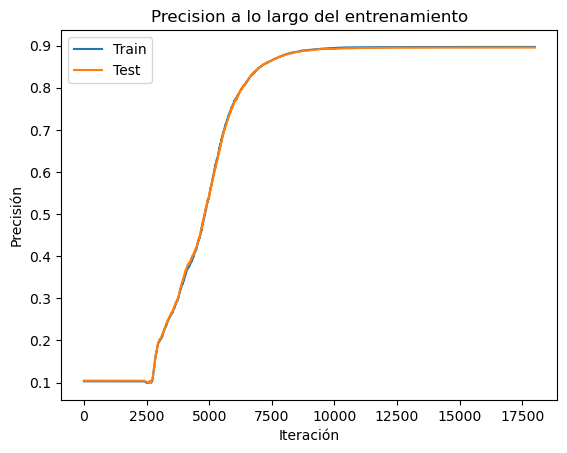

In [28]:

plt.plot(accuracy_train_values, label='Train')
plt.plot(accuracy_test_values, label='Test')
plt.xlabel('Iteración')
plt.ylabel('Precisión')
plt.title('Precision a lo largo del entrenamiento')
plt.legend()

# plt.xlim(10000, 10500)

plt.show()

In [ ]:
# L = 0.0001, 15000 iteraciones
print(f'Accuracy: {accuracy_test * 100:.2f}%')
print(f'Accuracy: {accuracy_train * 100:.2f}%')

Accuracy: 89.88%
Accuracy: 89.52%


In [ ]:
# L = 0.0001, 16000 iteraciones
print(f'Accuracy: {accuracy_test * 100:.2f}%')
print(f'Accuracy: {accuracy_train * 100:.2f}%')

Accuracy: 89.89%
Accuracy: 89.52%


In [11]:
# L = 0.0001, 17000 iteraciones
print(f'Accuracy: {accuracy_test * 100:.2f}%')
print(f'Accuracy: {accuracy_train * 100:.2f}%')

Accuracy: 89.69%
Accuracy: 89.62%


In [200]:
# L = 0.0001, 18000 iteraciones
print(f'Accuracy: {accuracy_test * 100:.2f}%')
print(f'Accuracy: {accuracy_train * 100:.2f}%')

Accuracy: 89.81%
Accuracy: 89.56%


# Red Neuronal con scikit-learn

In [18]:
columns = ["age", "hypertension", "heart_disease", "smoking_history", "bmi", "HbA1c_level", "blood_glucose_level"]
X = df_escalado[columns].values
Y = df_escalado["diabetes"].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1/3, random_state=3005200)

In [19]:
def sklearn_neural_network(x_train, x_test, y_train, y_test, hidden_layers_size, iterations, L):
    classifier = MLPClassifier(hidden_layer_sizes=(hidden_layers_size), activation='relu', solver='sgd', random_state=3005200, max_iter=iterations, learning_rate_init=L)
    classifier.fit(x_train, y_train)

    predictions = classifier.predict(x_test)

    accuracy = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    print(f"Accuracy: {accuracy}")
    print(report)

In [27]:
# Results with sgd solver and minMax normalization instead of adam
sklearn_neural_network(X_train, X_test, Y_train, Y_test, (45,), 30000, 0.005)

Accuracy: 0.960549229738781
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     13380
           1       0.95      0.65      0.78      1550

    accuracy                           0.96     14930
   macro avg       0.96      0.83      0.88     14930
weighted avg       0.96      0.96      0.96     14930



In [22]:
# Results with sgd solver and z-score normalization instead of adam and minMax
sklearn_neural_network(X_train, X_test, Y_train, Y_test, (45,), 30000, 0.005)

Accuracy: 0.960549229738781
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     13380
           1       0.95      0.65      0.78      1550

    accuracy                           0.96     14930
   macro avg       0.96      0.83      0.88     14930
weighted avg       0.96      0.96      0.96     14930



In [132]:
sklearn_neural_network(X_train, X_test, Y_train, Y_test, (15,10,), 15000, 0.005)

Accuracy: 0.966912257200268
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     13451
           1       0.94      0.71      0.81      1479

    accuracy                           0.97     14930
   macro avg       0.95      0.85      0.90     14930
weighted avg       0.97      0.97      0.96     14930



In [332]:
sklearn_neural_network(X_train, X_test, Y_train, Y_test, (15,10,), 15000, 0.005)

Accuracy: 0.9642330877427997
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     13380
           1       0.96      0.69      0.80      1550

    accuracy                           0.96     14930
   macro avg       0.96      0.84      0.89     14930
weighted avg       0.96      0.96      0.96     14930



In [352]:
sklearn_neural_network(X_train, X_test, Y_train, Y_test, (100,5), 15000, 0.001)

Accuracy: 0.9626925653047556
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     13380
           1       0.93      0.70      0.79      1550

    accuracy                           0.96     14930
   macro avg       0.95      0.84      0.89     14930
weighted avg       0.96      0.96      0.96     14930



In [355]:
sklearn_neural_network(X_train, X_test, Y_train, Y_test, (25,), 15000, 0.005)

Accuracy: 0.9649028801071667
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     13380
           1       0.98      0.68      0.80      1550

    accuracy                           0.96     14930
   macro avg       0.97      0.84      0.89     14930
weighted avg       0.97      0.96      0.96     14930



In [372]:
sklearn_neural_network(X_train, X_test, Y_train, Y_test, (45,), 15000, 0.005)

Accuracy: 0.9650368385800402
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     13380
           1       0.97      0.69      0.80      1550

    accuracy                           0.97     14930
   macro avg       0.97      0.84      0.89     14930
weighted avg       0.97      0.97      0.96     14930



In [385]:
sklearn_neural_network(X_train, X_test, Y_train, Y_test, (45,), 125, 0.005)

Accuracy: 0.9650368385800402
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     13380
           1       0.97      0.69      0.80      1550

    accuracy                           0.97     14930
   macro avg       0.97      0.84      0.89     14930
weighted avg       0.97      0.97      0.96     14930

